# Install libraries

In [1]:
!pip3 install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

## Data down

- 데이터 다운로드
  - KorQuAD 1.0 데이터 (https://korquad.github.io/KorQuad%201.0/) 에서 Training set, Dev set 다운로드 후 Google Drive에 업로드
- 데이터 구성
  - 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍
  - Training set 60,407 개, Dev set 5,774 개의 질의응답쌍


In [3]:
import os
import json
import numpy
import matplotlib.pyplot as plt

from transformers import ElectraModel, ElectraTokenizer

In [4]:
DATAPATH = '/content/drive/MyDrive/NLP_Dataset/KorQuAD_1.0_Dataset'
filenames = [x for x in os.listdir (DATAPATH) if x.endswith('json')]
filenames.sort()
filenames

['KorQuAD_v1.0_dev.json', 'KorQuAD_v1.0_train.json']

In [5]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

data[0]

{'paragraphs': [{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'text': '1악장', 'answer_start': 421}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
     'id': '6566495-0-2',
     'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
    {'answers': [{'text': '파우스트', 'answer_start': 15}],
     'id': '6566518-0-0',
     'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
    {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
     'id': '6566518-0-1',
     'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
    {'answers': [{'text': '1839', 'answer_start': 0}],
     'id': '5917067-0-0',
     'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
    {'answers': [{'text': '파리', 'answer_start': 410}],
     'id': '5917067-0-1',
     'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
    {'answers': [{'text': '드레스덴', 'answer_sta

## Model & Tokenizer load

In [6]:
# KoELECTRA-Base-v3
model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

## train dataset

In [7]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  ## context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == '[UNK]':
        cont_unk_num += 1

    ## qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1

      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

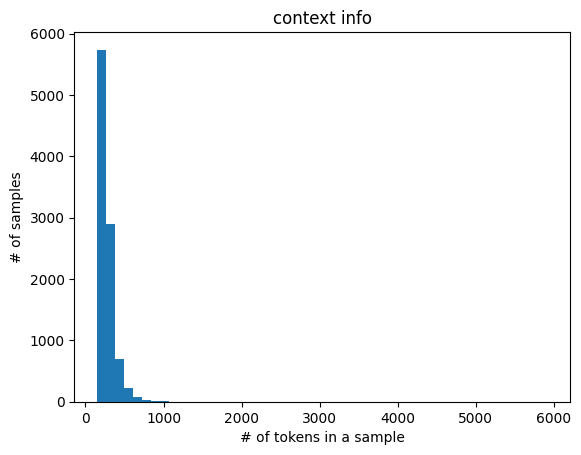

--------------- context info ---------------
# of paragraphs = 1420 | # of contexts = 9681
min = 147 | mean = 274.51 | median = 245.00 | max = 5925
# of [UNK] tokens = 2655 | % of [UNK] tokens = 0.10%


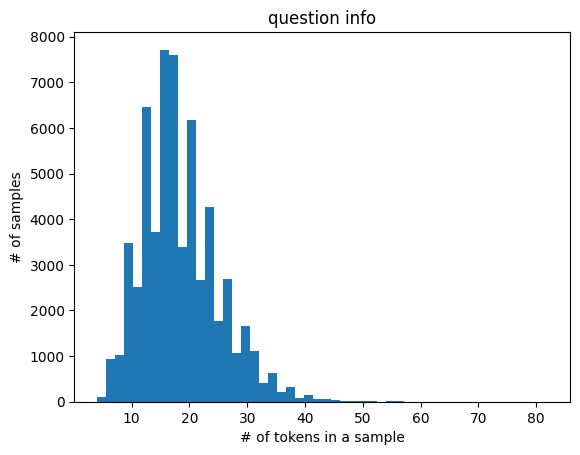

--------------- question info ---------------
# of questions = 60407
min = 4 | mean = 18.46 | median = 18.00 | max = 82
# of [UNK] tokens = 110 | % of [UNK] tokens = 0.01%


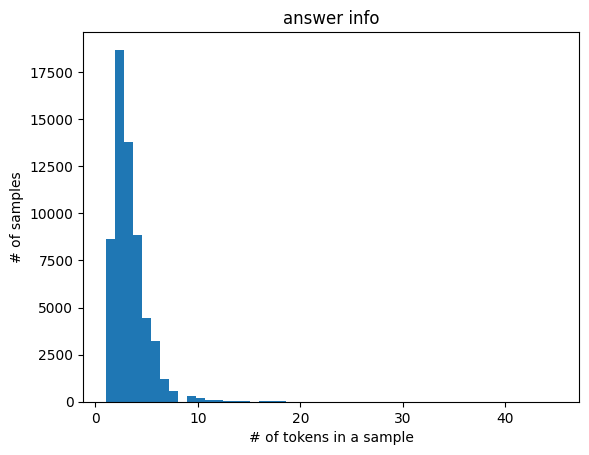

--------------- answer info ---------------
# of answers = 60407
min = 1 | mean = 3.12 | median = 3.00 | max = 45
# of [UNK] tokens = 109 | % of [UNK] tokens = 0.06%


In [8]:
## context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('--------------- context info ---------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

## question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

## answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

## valid dataset

In [9]:
file = filenames[0]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [10]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  ## context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == '[UNK]':
        cont_unk_num += 1

    ## qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1

      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

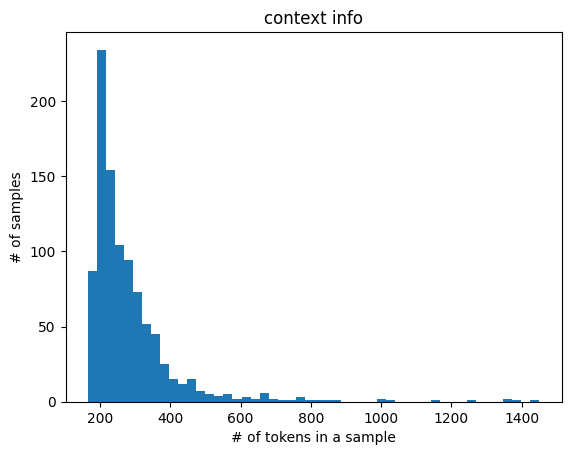

--------------- context info ---------------
# of paragraphs = 140 | # of contexts = 964
min = 166 | mean = 284.69 | median = 244.50 | max = 1450
# of [UNK] tokens = 246 | % of [UNK] tokens = 0.09%


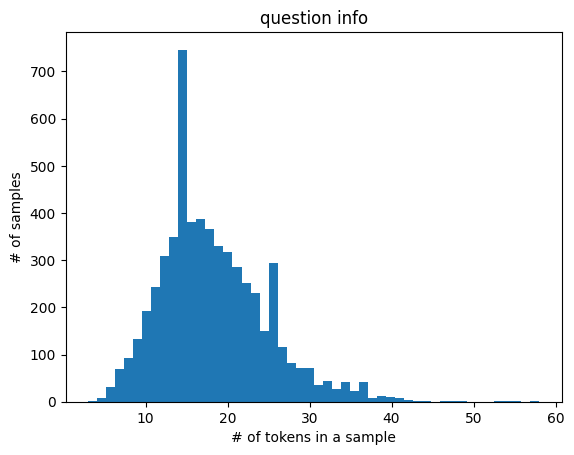

--------------- question info ---------------
# of questions = 5774
min = 3 | mean = 18.19 | median = 17.00 | max = 58
# of [UNK] tokens = 9 | % of [UNK] tokens = 0.01%


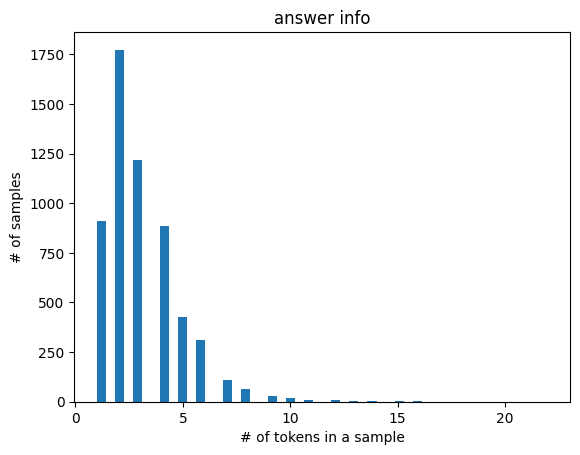

--------------- answer info ---------------
# of answers = 5774
min = 1 | mean = 3.08 | median = 3.00 | max = 22
# of [UNK] tokens = 10 | % of [UNK] tokens = 0.06%


In [11]:
## context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('--------------- context info ---------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

## question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

## answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

In [12]:
import torch
import logging
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor, squad_convert_examples_to_features

logger = logging.getLogger(__name__)


def load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False):
    if args.local_rank not in [-1, 0] and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()

    # Load data features from cache or dataset file
    input_dir = args.data_dir if args.data_dir else "."
    cached_features_file = os.path.join(
        input_dir,
        "cached_{}_{}_{}".format(
            "dev" if evaluate else "train",
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_length),
        ),
    )

    # Init features and dataset from cache if it exists
    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features_and_dataset = torch.load(cached_features_file)
        features, dataset, examples = (
            features_and_dataset["features"],
            features_and_dataset["dataset"],
            features_and_dataset["examples"],
        )
    else:
        logger.info("Creating features from dataset file at %s", input_dir)

        if not args.data_dir and ((evaluate and not args.predict_file) or (not evaluate and not args.train_file)):
            try:
                import tensorflow_datasets as tfds
            except ImportError:
                raise ImportError("If not data_dir is specified, tensorflow_datasets needs to be installed.")

            if args.version_2_with_negative:
                logger.warning("tensorflow_datasets does not handle version 2 of SQuAD.")

            tfds_examples = tfds.load("squad")
            examples = SquadV1Processor().get_examples_from_dataset(tfds_examples, evaluate=evaluate)
        else:
            processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
            if evaluate:
                examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)
            else:
                examples = processor.get_train_examples(args.data_dir, filename=args.train_file)

        features, dataset = squad_convert_examples_to_features(
            examples=examples,
            tokenizer=tokenizer,
            max_seq_length=args.max_seq_length,
            doc_stride=args.doc_stride,
            max_query_length=args.max_query_length,
            is_training=not evaluate,
            return_dataset="pt",
            threads=args.threads,
        )

        if args.local_rank in [-1, 0]:
            logger.info("Saving features into cached file %s", cached_features_file)
            torch.save({"features": features, "dataset": dataset, "examples": examples}, cached_features_file)

    if args.local_rank == 0 and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()

    if output_examples:
        return dataset, examples, features
    return dataset


# Modeling

In [13]:
%cd '/content/drive/Othercomputers/내 컴퓨터/GitHub/nlp/KoELECTRA_for_question_answering-mrc-_with_korquad_dataset'

/content/drive/Othercomputers/내 컴퓨터/GitHub/nlp/KoELECTRA_for_question_answering-mrc-_with_korquad_dataset


In [14]:
!ls

evaluate.py  KoECECTRA_MRC_.ipynb  LICENSE  __pycache__  README.md  run_korquad.py  runs


## Training
- 하이퍼파라미터 설정
  - model_type
    - transformers의 MODEL_FOR_QUESTION_ANSWERING_MAPPING 목록에 있는 모델 종류 중 선택
    - 'albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'bloom', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'flaubert', 'fnet', 'funnel', 'gptj', 'ibert', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'longformer', 'mbart', 'megatron-bert', 'mobilebert', 'reformer', 'rembert', 'roberta', 'roformer', 'splinter', 'squeezebert', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'yoso’ 등
  - model_name_or_path
    - 사전 학습 모델 경로 혹은 huggingface.co/models에 업로드 된 model idenfitier
  - output_dir
    - 모델의 checkpoint 및 prediction 파일 저장 경로
  - data_dir
    - 데이터셋 경로. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - train_file
    - 학습 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - predict_file
    - 평가 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - config_name
    - model_name과 동일하지 않을 시 설정하는 config 이름 혹은 경로
  - tokenizer_name
    - model_name과 동일하지 않을 시 설정하는 tokenizer 이름 혹은 경로
  - cache_dir
    - huggingface.co에서 다운로드한 사전 학습 모델 저장 경로
  - version_2_with_negative
    - no-answer 포함하는 데이터셋일 경우 true로 설정
  - null_score_diff_threshold
    - null_score - best_non_null이 prediction null의 threshold보다 큰 경우
  - max_seq_length
    - WordPiece로 토크나이징 후 input sequence의 길이. max_seq_length보다 길면 truncate, 짧으면 padding
  - doc_stride
    - 긴 문서를 chunk로 분할할 때 chunk 사이에 겹치는 토큰 수 (stride)
  - max_query_length
    - 질문 토큰의 최대 길이. max_query_length보다 길면 truncate
  - do_train
    - 학습 여부
  - do_eval
    - 평가 여부
  - evaluate_during_training
    - 학습 시 logging step마다 평가 여부
  - do_lower_case
    - uncased 모델일 경우 설정. 한국어 모델은 uncased 모델
  - per_gpu_train_batch_size
    - 학습 시 batch size
  - per_gpu_eval_batch_size
    - 평가 시 batch size
  - learning_rate
    - Adam optimizer의 초기 learning rate
gradient_accumulation_steps
    - backward/update pass 시 쌓을 steps 수
batch size가 커서 OOM 에러가 발생할 때, mini-batch를 통해 구해진 gradient를 global gradient에 누적시킨 후 한번에 update
    - 예: batch_size = 16, gradient_accumulation_steps = 16 이면 batch _size = 256의 효과이나 학습 시간이 매우 길어짐
  - weight_decay
    - overfitting을 막기 위한 weight decay
  - adam_epsilon
    - Adam optimizer의 epsilon 값
  - max_grad_norm
    - grandient clipping을 위한 max gradient norm
  - num_train_epochs
    - 학습 epoch 수
  - max_steps
    - 학습 step 수. 0보다 크면 num_train_epochs을 상속받음.
  - warmup_steps
    - linear warmup 을 위한 step 수
  - n_best_size
    - nbest_prediction.json 파일을 통해 생성되는 n-best prediction의 개수
  - max_answer_length
    - 생성할 수 있는 최대 정답의 길이
  - verbose_logging
    - true로 설정 시 데이터 전처리 시 발생하는 warning 모두 출력
  - lang_id
    - language-specific xlm 모델을 위한 값. (ELECTRA와는 상관 없음)
  - logging_steps
    - n step 마다 로그 작성
  - save_steps
    - n step 마다 checkpoint 저장
  - eval_all_checkpoints
    - 모든 checkpoint 평가 여부
  - no_cuda
    - true로 설정 시 GPU 사용하지 않음
  - overwrite_output_dir
    - output 디렉토리 overwrite 여부
  - overwrite_cache
    - cache 파일 overwrite 여부
  - seed
    - 초기화를 위한 random seed
  - local_rank
    - GPU 분산 학습을 위한 local rank
  - fp16
    - NVIDIA apex를 통해 계산량을 줄이기 위한 목적으로 single(fp32)와 half(fp16)를 섞은 mixed precision 사용 여부
    - master weigth를 fp32에서 fp16로 변환한 후 back/forward propagatio은 fp16로 연산 수행. 이후 weight update 시 다시 fp32
  - fp16_opt_level
    - Apex AMP optimization
  - server_ip
    - distant debugging을 위해 사용
  - server_port
    - distant debugging을 위해 사용
  - threads
    - example에서 feature 생성할 때 사용할 multiple threads

In [15]:
from transformers import MODEL_FOR_QUESTION_ANSWERING_MAPPING

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

print(MODEL_TYPES)

('albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'bloom', 'camembert', 'canine', 'convbert', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'falcon', 'flaubert', 'fnet', 'funnel', 'gpt2', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'longformer', 'luke', 'lxmert', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'opt', 'qdqbert', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'splinter', 'squeezebert', 't5', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso')


In [ ]:
# 파일 이름 혹 디렉토리 이름은 띄어쓰기 하면 안 됨.

!python run_korquad.py \
    --model_type electra \
    --model_name_or_path monologg/koelectra-base-v3-discriminator \
    --output_dir /content/drive/MyDrive/NLP_Model/ELECTRA/ckpt \
    --data_dir /content/drive/MyDrive/NLP_Dataset/KorQuAD_1.0_Dataset \
    --train_file KorQuAD_v1.0_train.json \
    --predict_file KorQuAD_v1.0_dev.json \
    --max_seq_length 512 \
    --doc_stride 128 \
    --max_query_length 64 \
    --do_train \
    --do_eval \
    --evaluate_during_training \
    --per_gpu_train_batch_size=16 \
    --per_gpu_eval_batch_size=8 \
    --learning_rate 5e-5 \
    --gradient_accumulation_steps 1 \
    --weight_decay 0.0 \
    --adam_epsilon 1e-8 \
    --max_grad_norm 1.0 \
    --num_train_epochs 3 \
    --max_steps -1 \
    --warmup_steps 0 \
    --n_best_size 20 \
    --max_answer_length 30 \
    --verbose_logging \
    --logging_steps 1000 \
    --save_steps 1000 \
    --eval_all_checkpoints \
    --overwrite_output_dir \
    --seed 42 \
    --local_rank -1 \
    --threads 4

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,012 >> Unable to find text: '##개명이' in '창씨개명이'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,012 >> Unable to find text: '##명이 강요' in '창씨개명이 강요되었던'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,012 >> Unable to find text: '##이 강요되었던 시절에 ( 당시 13세 ) , 가네무라 고유 ( 金 村 康 右 ) 라는 이름으로 창씨개명' in '창씨개명이 강요되었던 시절에(당시 13세), 가네무라 고유(金村康右)라는 이름으로 창씨개명을'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,013 >> Unable to find text: '##씨개명이 강요' in '창씨개명이 강요되었던'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,013 >> Unable to find text: '##명' in '창씨개명을'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,013 >> Unable to find text: '##씨' in '창씨개명이'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,013 >> Unable to find text: '##명이 강요되었던 시절에 ( 당시 13세 ) , 가네무라 고유 ( 金 村 康 右 ) 라는 이름으로 창' in '창씨개명이 강요되었던 시절에(당시 13세), 가네무라 고유(金村康右)라는 이름으로 창씨개명을'
[INFO|squad_metrics.py:305] 2024-01-31 15:13:32,014 >> Unable to find text: '##학교' in '

## Evaluation

In [16]:
from evaluate import evaluate_result, analyze_result

dataset_file = '/content/drive/MyDrive/NLP_Dataset/KorQuAD_1.0_Dataset/KorQuAD_v1.0_dev.json'
prediction_file = '/content/drive/MyDrive/NLP_Model/ELECTRA/ckpt/predictions_.json'
evaluate_result(dataset_file, prediction_file)

{'exact_match': 86.07551091098026, 'f1': 94.36867834752634}

### 에러 케이스

In [17]:
f1_threshold = 0.85
model_name_or_path = 'monologg/koelectra-base-v3-discriminator'
result = analyze_result(dataset_file, prediction_file, f1_threshold, model_name_or_path)

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


In [18]:
result

,context,question,answer,prediction,f1 score,context length,question length,answer length
0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석을 검거한 장소는 경희대 내 어디인가?,학생회관 건물 계단,서울청량리경찰서는,0.000000,257,13,4
1,"알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr....",로널드 레이건 정부 출범 당시 알렉산더 헤이그는 어떤 직책을 맡았는가?,초대 국무장관직,국무장관직,0.833333,190,16,5
2,"알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr....",알렉산더 헤이그는 어느 대통령의 밑에서 국무장관을 지냈는가?,로널드 레이건 대통령,로널드 레이건,0.800000,190,17,3
3,헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논...,알렉산더 헤이그를 사성 장군과 육군 부참모로 진급시킨 대통령은 누구인가?,닉슨 대통령,닉슨,0.571429,200,20,2
4,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",노아의 방주를 만든 재질은?,고페르나무(잣나무),고페르나무,0.769231,328,9,7
...,...,...,...,...,...,...,...,...
644,영생교는 기독교 등 다른 종교가 '사후(死後) 영생' 또는 '사후(死後) 극락'의 ...,영생교에서 보는 사람의 실체는 원래 무엇이라고 여기는가?,신,신이,0.666667,228,18,1
645,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,후면 카메라는 몇만 화소 카메라를 탑재했나?,"1,200만 화소","1,200만",0.833333,267,12,5
646,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,S7엣지의 후면 카메라의 화소는?,"1,200만 화소","1,200만",0.833333,267,11,5
647,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,갤럭시 S7 엣지의 후면 카메라에는 어떤 기술이 적용되었는가?,OIS,OIS 기술,0.750000,267,18,2


In [19]:
result['context'][0]

'1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.'

In [20]:
result['question'][0]

'임종석을 검거한 장소는 경희대 내 어디인가?'

In [21]:
result['answer'][0]

'학생회관 건물 계단'

In [27]:
dataset_file

'/content/drive/MyDrive/NLP_Dataset/KorQuAD_1.0_Dataset/KorQuAD_v1.0_dev.json'

In [28]:
f1_threshold = 0.55
model_name_or_path = 'monologg/koelectra-base-v3-discriminator'
result = analyze_result(dataset_file, prediction_file, f1_threshold, model_name_or_path)

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


In [29]:
result

,context,question,answer,prediction,f1 score,context length,question length,answer length
0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석을 검거한 장소는 경희대 내 어디인가?,학생회관 건물 계단,서울청량리경찰서는,0.000000,257,13,4
1,역사학과 과학이 발달하지 않았던 과거 전통 신학계에서는 근본주의적 시각을 받아들여 ...,전통 신학계의 근본주의적 시작을 여전히 받아들여 노아의 방주를 역사적 사실로 인식하...,보수적 근본주의계열의 개신교,개신교,0.375000,196,26,8
2,역사학과 과학이 발달하지 않았던 과거 전통 신학계에서는 근본주의적 시각을 받아들여 ...,현재도 노아의 방주를 역사적 사실로 받아들이는 집단은?,보수적 근본주의계열의 개신교,개신교,0.375000,196,16,8
3,"기독교 성경 내용에는 모든 종들을 방주에 태운다고 이야기하고 있으나, 어류나 수중 ...",노아의 홍수가 실재한다면 진화적 종분화가 얼마 만에 이루어져야하는가?,3-4천년,엄청난 속도,0.000000,554,20,5
4,1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양...,막부 해군이 정박하고 있던 시나가와 해역을 탈출한 시간은?,자정,8월 19일 자정,0.444444,308,17,1
...,...,...,...,...,...,...,...,...
264,"나폴레옹이 근위대와 함께 중계점인 크라스니 마을로 들어가는 것을 방치한 후, 그가 ...",3천명의 사상자를 내며 우세를 점한 군대는?,골리친의 군대,줄곧,0.000000,658,15,4
265,"나폴레옹이 근위대와 함께 중계점인 크라스니 마을로 들어가는 것을 방치한 후, 그가 ...",쿠투조프에게 군대를 학살당하는 상황에서 유일하게 살아남은 인물은?,네,줄곧,0.000000,658,23,1
266,나폴레옹은 동브로프스키의 연대를 바리사우에 먼저 보내어 수비하게 했는데 이 정보를 ...,비트겐슈타인 군대의 압박으로 다리폭파를 결단하게 된 장수는 누구인가?,에블레,약간,0.000000,537,21,3
267,11월 말에 남은 정규군을 이끌고 베레지나 강을 건너 에움을 벗어나는 데 성공한 나...,힘든 여정 끝에 나폴레옹이 러시아군을 벗어났던 지점은?,빌뉴스,에움,0.000000,235,14,2
